# Sistemas de recomendación:

Beatriz Cárdaba y Sara Bengoechea

- Librerías
- Data Set
- Teoría
- Definición algortimo
- Pueba de algoritmo
- Evaluación del modelo
- Conclusiones generales


### Librerías:
Cargamos las librerías necesarias:

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from wordcloud import WordCloud, STOPWORDS
import ast
import plotly
import plotly.offline as py
from surprise import SVD, Reader, Dataset 
from surprise.model_selection import cross_validate
from surprise.model_selection import cross_validate, train_test_split
from sklearn.metrics import mean_squared_error

## Collaborative filtering

La idea del filtrado colaborativo es considerar las opiniones de los usuarios sobre las distintas películas y recomendar la mejor película a cada usuario basándose en las clasificaciones anteriores del usuario y en la opinión de otros tipos de usuarios similares.

Este tipo de filtro se basa en la combinación del comportamiento del usuario y en la comparación y el contraste con el comportamiento de otros usuarios en la base de datos. La historia de todos los usuarios juega un papel importante en este algoritmo. La principal diferencia entre el Content Based Filtering y el Collaborative filtering es que en este último, la interacción de todos los usuarios con los elementos influye en el algoritmo de recomendación, mientras que para el filtrado basado en el contenido sólo se tienen en cuenta los datos del usuario afectado.
Hay múltiples formas de aplicar el filtrado en colaboración, pero el concepto principal que hay que captar es quelos datos de múltiples usuarios influyen en el resultado de la recomendación y no dependen de los datos de un solo usuario para la modelización.


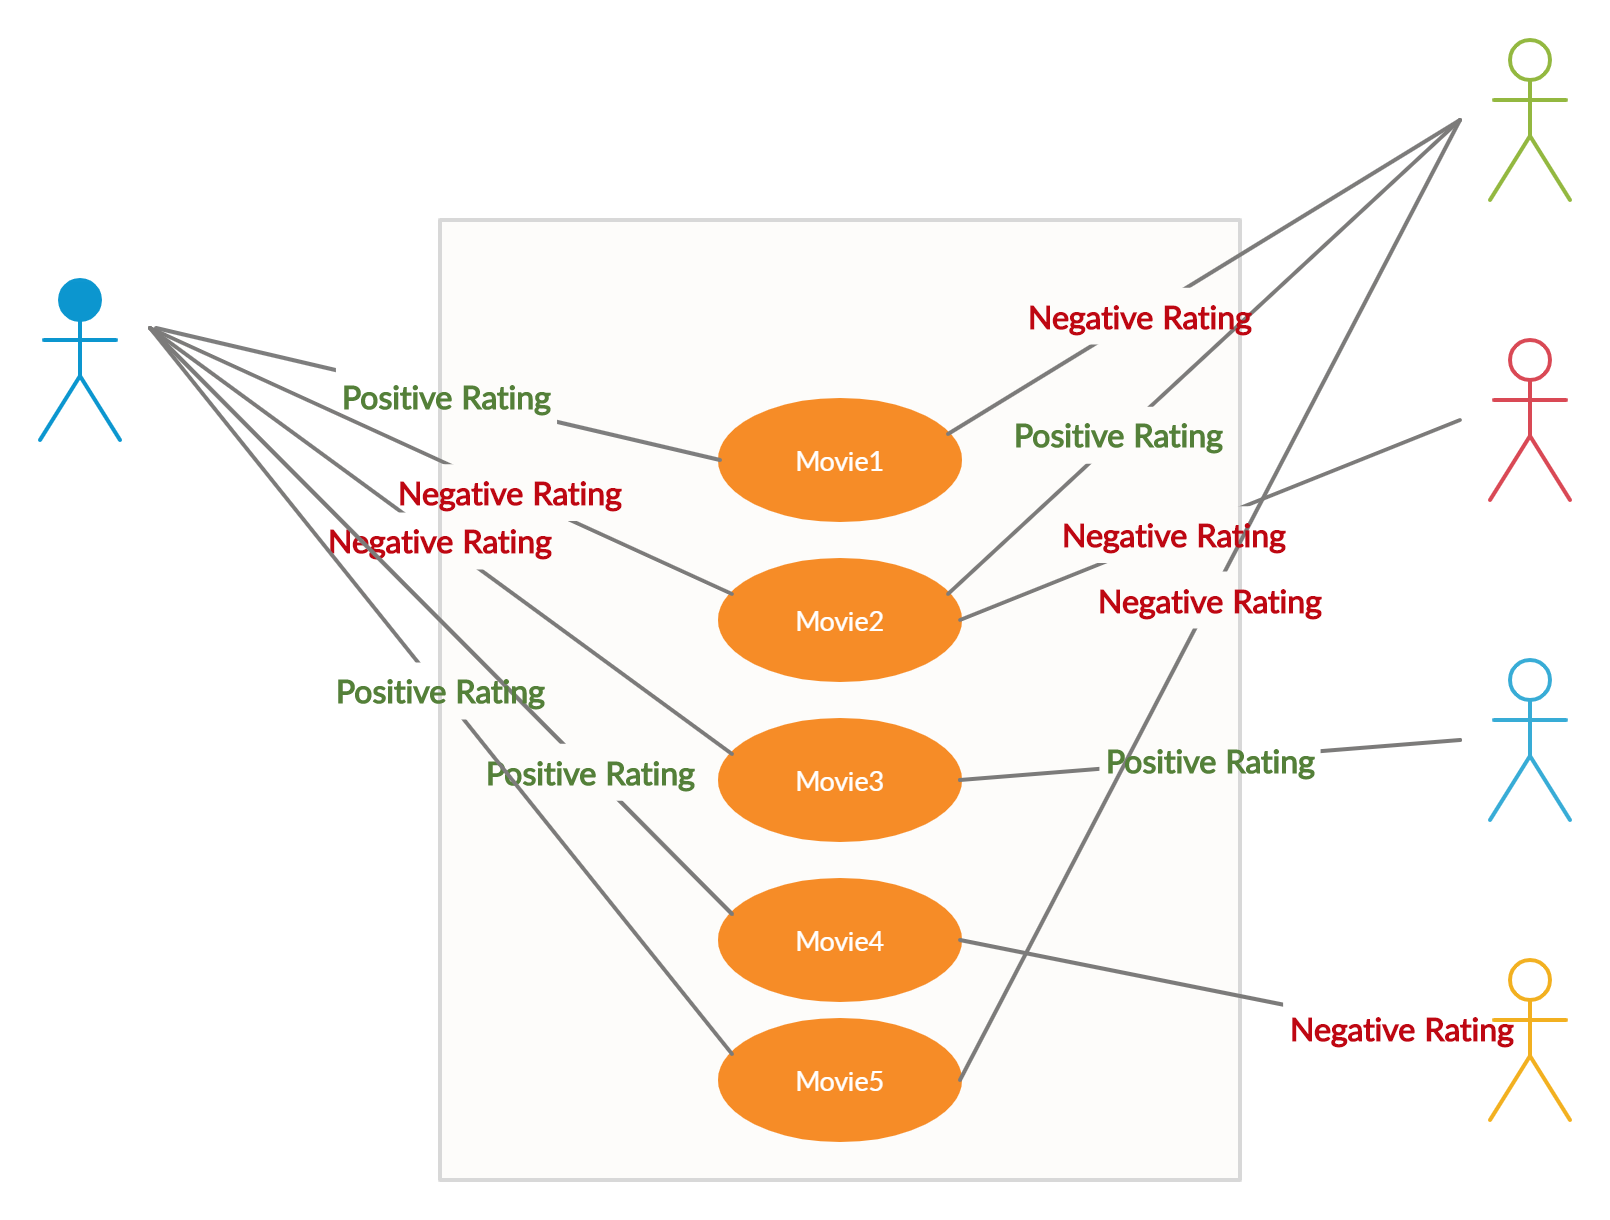


Se distinguen dos tipos de collaborative filtering:
 - User-based Collaborative filtering
 - Item-based Collaborative Filtering

### User-User collaborative filtering

Encuentra puntuaciones de similitud entre los usuarios para elegir a los usuarios más similares y recomienda productos que estos usuarios similares han gustado o comprado anteriormente.

En el caso de las películas, este algoritmo encuentra la similitud entre cada usuario basándose en las puntuaciones que han dado previamente a diferentes películas. La predicción de un artículo para un usuario u se calcula calculando la suma ponderada de las puntuaciones de usuario dadas por otros usuarios a un artículo i. Así, la predicción para el usuario 'u' se da como:

P(u,i) = E [r(v,i) * s(u,v)] / E [S(u,v)]

donde,

Pu, i es la predicción de un elemento
Rv, i es la calificación dada por un usuario v a una película i
Su,v es la similitud entre los usuarios

Pasos básicos para esto:

Para las predicciones necesitamos la similitud entre el usuario u y v. Podemos hacer uso de la correlación de Pearson.
Primero encontramos los elementos calificados por ambos usuarios y en base a las calificaciones, se calcula la correlación entre los usuarios.
Las predicciones pueden ser calculadas usando los valores de similitud. Este algoritmo, en primer lugar calcula la similitud entre cada usuario y luego basado en cada similitud calcula las predicciones. Los usuarios que tengan una mayor correlación tenderán a ser similares.
Desventaja: este algoritmo requiere bastante tiempo, ya que implica el cálculo de la similitud para cada usuario y luego calcula la predicción para cada puntaje de similitud. Una forma de manejar este problema es seleccionar sólo unos pocos usuarios (vecinos) en lugar de todos para hacer predicciones, es decir, en lugar de hacer predicciones para todos los valores de similitud, elegimos sólo unos pocos valores de similitud. Hay varias maneras de seleccionar los vecinos:

 - Seleccionar un umbral de similitud y elegir todos los usuarios por encima de ese valor
 - Selecciona al azar a los usuarios
 - Ordena los vecinos en orden descendente de su valor de similitud y elige los usuarios top-N
 - Usar la agrupación para elegir los vecinos
 
Este algoritmo es útil cuando el número de usuarios es menor. No es efectivo cuando hay un gran número de usuarios, ya que llevará mucho tiempo calcular la similitud entre todos los pares de usuarios. Esto nos lleva a un filtrado colaborativo item-item, que es efectivo cuando el número de usuarios es mayor que los artículos recomendados.


### Item-Item collaborative filtering
Se encuentran similitudes entre cada uno de las películas y en base a eso, se hacen recomendaciones de películas similares para el usuario.

Este algoritmo funciona de manera similar al filtrado colaborativo usuario-usuario con sólo un pequeño cambio: en lugar de tomar la suma ponderada de las clasificaciones de "“user-neighbors”", tomamos la suma ponderada de las clasificaciones de "“item-neighbors”".
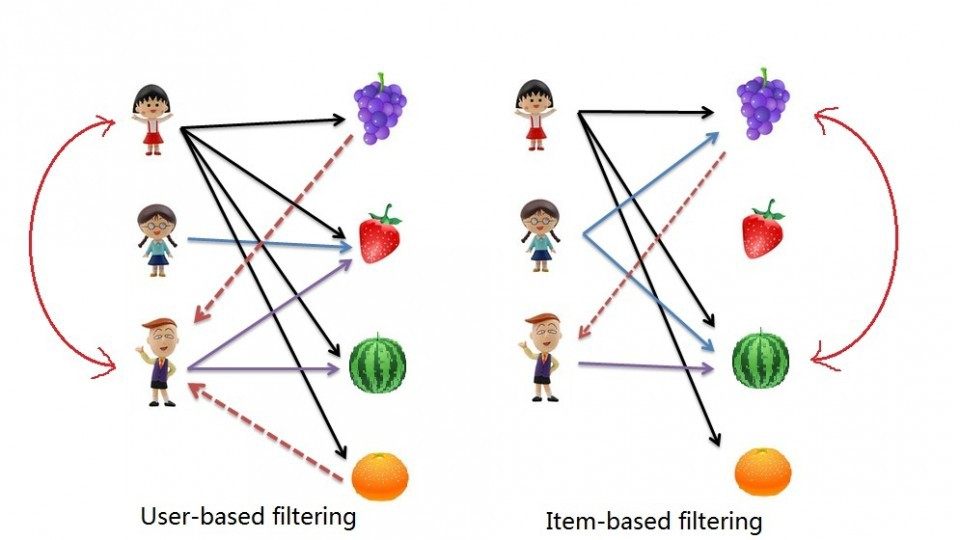


Este método presenta un problema de escalabilidad  y falta de de algunos datos. En casos extremos, podemos tener millones de usuarios y la similitud entre dos películas bastante diferentes podría ser muy alta simplemente porque tienen un rango similar para el único usuario que las clasificó a ambas.


Una forma de manejar el problema de la escalabilidad y la escasez de datos creado por el filtro, es aprovechar un modelo de factores latentes (las variables latentes o variables ocultas, son las variables que no se observan directamente sino que son inferidas a través de un modelo matemático a partir de otras variables que se observan) para calcular la similitud entre los usuarios y los artículos. 

Esencialmente, queremos convertir el problema de recomendación en un problema de optimización. Podemos verlo como lo buenos que somos en la predicción de la calificación de los artículos dados a un usuario. Una métrica común es el error cuadrado medio de la raíz (RMSE). Cuanto más bajo es el RMSE, mejor es el rendimiento.


En lugar de implementar un filtrado colaborativo desde cero, utilizaremos la librería Surprise que utiliza algoritmos extremadamente poderosos como la Descomposición del Valor Singular (SVD) para minimizar el RMSE (Root Mean Square Error) y dar buenas recomendaciones



### Data set utilizado:
En este caso este sistema de filtrado solo tendrá en cuenta las puntuaciones que los usuarios dan a las diferentes películas por la que en este caso utilizaremos:

- Ratings: recoge las puntucaciones que cada usuario da a cada película

In [2]:
df_rating= pd.read_csv('../data/01_raw/ratings_small.csv')
df_rating.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [3]:
# nombramos el algoritmo SVD 
svd = SVD()

In [4]:
# nombramos la funcion reader para que sea capaz de leer los datos en la forula
reader = Reader()

In [5]:
# cargamos los datos que vamos a utilizar para crear el algoritmo
# indicamos las columnas que nos interesa + reader
data = Dataset.load_from_df(df_rating[['userId', 'movieId', 'rating']], reader)

__Definimos el algorimo__

Para definir el algorimo utilizamos cross validation y como hemos explicado anteriormente queremos minimizar el RMSE. 

El objetivo de este algoritmo será crear un modelo capaz de predecir la puntuación que un usuario va a dar a una película antes de que éste la haya visualizado. Esta predección la realizará el modelo a partir de las calificaciones que otros usuarios han dado a las películas

In [6]:
%time
# utilizamos cross validation decimos que 5 veces
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True,  n_jobs = 2)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8994  0.8954  0.8941  0.8927  0.8960  0.8955  0.0023  
MAE (testset)     0.6943  0.6880  0.6912  0.6901  0.6889  0.6905  0.0022  
Fit time          6.09    6.05    6.21    6.18    5.68    6.04    0.19    
Test time         0.16    0.20    0.16    0.19    0.15    0.17    0.02    


{'test_rmse': array([0.89942792, 0.89540045, 0.89406095, 0.89266466, 0.89597858]),
 'test_mae': array([0.69427029, 0.68797512, 0.69119749, 0.69011151, 0.68885286]),
 'fit_time': (6.093077898025513,
  6.054597854614258,
  6.213413238525391,
  6.184016942977905,
  5.676296234130859),
 'test_time': (0.16054201126098633,
  0.1983506679534912,
  0.16013836860656738,
  0.19208812713623047,
  0.15104007720947266)}

Obtenemosun RMSE medio 0.897, que es más que suficiente para nuestro caso. Ahora vamos a entrenar el modelo para que pueda hacer predicciones con cualquier película y usuario.

- Creamos el train set

In [7]:

trainset = data.build_full_trainset() # crea el data set a partir de data (creado anteriormente con los datos disponibles)

- Entrenamos el modelo con el trainset

In [8]:
# entrenamos el modelo con el trainset
svd.fit(trainset)

- Visualizamos las recomendaciones que ha dado el usuario 1

In [9]:
df_rating[df_rating['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


- Predecimos con el modelo la puntuación de una película del test set

In [10]:
# predict ratings for the testset
svd.predict(uid=1, iid=302, r_ui=None)

Prediction(uid=1, iid=302, r_ui=None, est=2.864457521520192, details={'was_impossible': False})

In [11]:
# Para que devuelva directamente la puntuación estimada
svd.predict(uid=1, iid=302, r_ui=None).est

2.864457521520192

Para la película con ID 302, tenemos una predicción estimada de 2.77. Esto quiere decir, que antes de ver l a pelicula se estima que el usuario 1 dará una puntuación de 2.77 a la pelicula con id 302 en base a las puntutaciones que ha dado a otras peliculas y en base a las puntuaciones que han dado otros usuarios.

### Evaluación del modelo

In [17]:
trainst, testset = train_test_split(data, test_size = .25)

In [18]:
test = svd.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace = True, axis= 1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
test.tail()

,userId,movieId,actual,cf_predictions
24996,401,1376,5.0,4.527352
24997,111,3967,3.5,3.769736
24998,320,2571,4.5,4.235151
24999,615,4886,4.5,4.072449
25000,306,2369,3.0,3.174595


Las ventajas de este método de recomendación es que no necesita conocer caraterísticas de las películas como el género ya que 
utiliza la información recopilada de otros usuarios para recomendar nuevos elementos al usuario actual. Sin embargo, no logra recomendar una nueva película que no tienen clasificaciones. Requiere de la comunidad de usuarios y puede tener un problema de escasez de datos.

### Conclusiones generales:

En este proyecto hemos implementado distintos algoritmos de recomendación aplicados a una base de datos con información acerca de películas. Estos han sido:
- Sistema de recomendación demográfico. Este es el sistema más simple de todos, ya que ofrece recomendaciones generalizadas a los usuarios basadas en la popularidad de la película y/o el género, recomendando lo mismo a aquellos usuarios con características demográficas similares.


- Sistema de recomendación basado en el contenido. Para este sistema hemos elaborado dos algoritmos: uno basado en la descripción de la película y otro basado en un conjunto de metadatos (director, actores, géneros relacionados y palabras clave de la trama).


- Sistema de recomendación colaborativo. Este algoritmo se caracteriza por recomendar artículos en base a las opiniones de los usuarios similares. Aunque este sistema es de gran utilidad, tiene la desventaja de requerir que la comunidad de usuarios puntúe las películas.

A través de la elaboración de los sistemas de recomendación, se resuelve uno de los grandes problemas de la actualidad: el exceso de información. De esta manera, los usuarios tienen recomendaciones personalizadas para que consuman aquellos productos más afines a sus gustos. 

Mediante la realización de este trabajo hemos sido conscientes del conflicto entre la ética y el negocio que puede suponer la implementación de este tipo de algoritmos. Esto es debido a que grandes empresas como Netflix, Amazon o Spotify son capaces de generar unos beneficios muy altos al disponer de una gran cantidad de información sobre las preferencias de sus clientes, sin (en muchos casos) ser estos conscientes.

Adicionalmente, querríamos destacar la importancia de la extracción, procesamiento y estructuración de los datos para poder trabajar con ellos de manera eficiente. 


__Bibliografía:__
- https://github.com/Invince11/IMBD-Movie-Recommendation-System/blob/master/Movie-Recommendation.ipynb
- https://www.youtube.com/watch?v=P5mlg91as1c
https://www.researchgate.net/profile/Lasheng_Yu/publication/314250702_Movies_recommendation_system_using_collaborative_filtering_and_k-means/links/58e4a8c00f7e9bbe9c94dbb4/Movies-recommendation-system-using-collaborative-filtering-and-k-means.pdf
- https://www.geeksforgeeks.org/python-implementation-of-movie-recommender-system/#:~:text=Collaborative%20filtering%3A%20Collaborative%20filtering%20approaches,may%20have%20an%20interest%20in.
- https://www.datacamp.com/community/tutorials/recommender-systems-python
- https://www.youtube.com/watch?v=Fmtorg_dmM0&t=447s